In [195]:
"""
This script implements a smart crop of objects in an image depending on the size of the bounding box.
Our idea is to keep object smallest side size not less than some pixel_value.
Lets take 128 as reference.

"""
import os
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw

image_base_dir = "/home/slava/hdd/hdd4/Datasets/lct-drones/prod_data"

min_pixel_size = 128

def get_object_classes(image_labels):
    object_classes = []
    for image_label in image_labels:
        object_classes.append(image_label[0])
    return object_classes

def get_image_labels(image_labels_path):
    with open(image_labels_path, 'r') as f:
        image_labels = []
        for image_label in f.readlines():
            image_labels.append(list(map(float, image_label.strip().split())))
    return image_labels

def get_boxes_pixel_xyxy(image_labels, image_size):
    """
    Computes pixel box size of objects
    """
    shapes = []
    for image_label in image_labels:
        shape = [
            (image_label[1]-image_label[3]/2)*image_size[0],
            (image_label[2]-image_label[4]/2)*image_size[1],
            (image_label[1]+image_label[3]/2)*image_size[0],
            (image_label[2]+image_label[4]/2)*image_size[1]
        ]
        shapes.append(shape)
    return shapes

def get_objects_for_crop(boxes_pixel_xyxy, min_pixel_size):
    """
    Computes pixel box size of objects in one image 
    and returns objects that must be cropped and resized.
    """
    boxes_to_scale = []
    for box_pixel_xyxy in boxes_pixel_xyxy:
        k_w_min = 1
        k_h_min = 1
        width = box_pixel_xyxy[2] - box_pixel_xyxy[0]
        height = box_pixel_xyxy[3] - box_pixel_xyxy[1]
        if width < min_pixel_size:
            # Minimal coef for scaling witdth to match minimal requirement
            k_w_min = min_pixel_size / width
        if height < min_pixel_size:
            # Minimal coef for scaling witdth to match minimal requirement
            k_h_min = min_pixel_size / height

        scale_coef = max(k_w_min, k_h_min)
        if scale_coef>1:
            scale_coef *= np.random.uniform(1, 1.25) 
            boxes_to_scale.append((box_pixel_xyxy, scale_coef))
    return boxes_to_scale

def get_new_labels(crop, image_labels, object_classes):
    """
    crop  - xyxy
    image_labels  - xyxy
    """

    crop_width = crop[2]-crop[0]
    crop_height = crop[3]-crop[1]
    shifted_labels = []
    for image_label, object_class in zip(image_labels, object_classes):
        shifted_label = [
            image_label[0]-crop[0], #minx
            image_label[1]-crop[1], #miny
            image_label[2]-crop[0], #maxx
            image_label[3]-crop[1]  #maxy
        ]
        # cases to save shifted label (if it is not outside the crop)
        if not ( \
            (shifted_label[0] <= 0) or \
            (shifted_label[1] <= 0) or \
            (shifted_label[2] >= crop_width) or \
            (shifted_label[3] >= crop_height)
            ):
            shifted_labels.append(
                [object_class] + list(xyxy2yolo(
                    shifted_label, (crop_width, crop_height))))
            
    return shifted_labels

def xyxy2yolo(xyxy, image_size):
    x_center = (xyxy[0] + xyxy[2]) / 2 / image_size[0]
    y_center = (xyxy[1] + xyxy[3]) / 2 / image_size[1]
    width = (xyxy[2] - xyxy[0])/ image_size[0]
    height = (xyxy[3] - xyxy[1])/ image_size[1]
    return x_center, y_center, width, height

def yolo2xyxy(yolo, image_size):
    return ((yolo[0]-yolo[2]/2)*image_size[0],
            (yolo[1]-yolo[3]/2)*image_size[1],
            (yolo[0]+yolo[2]/2)*image_size[0],
            (yolo[1]+yolo[3]/2)*image_size[1])

def crop_objects(image, image_labels, object_classes, objects_for_crop, random=True):
    image_width, image_height = image.size
    image_aspect_ratio = image_width/image_height
    crops = []
    crops_new_labels = []
    for object_for_crop in objects_for_crop:
        scale = object_for_crop[1]
        xyxy = object_for_crop[0]
        width = xyxy[2]-xyxy[0]
        height = xyxy[3]-xyxy[1]
        x_center = int((xyxy[2]+xyxy[0])/2)
        y_center = int((xyxy[3]+xyxy[1])/2)

        if width<=height:
            aspect_ratio = width/height
            crop_width = image_width/scale
            crop_height = image_height/scale/aspect_ratio*image_aspect_ratio
        elif width>height:
            aspect_ratio = height/width
            crop_height = image_height/scale
            crop_width = image_width/scale/aspect_ratio/image_aspect_ratio

        x_center_coef = 0
        y_center_coef = 0
        if random:
            x_center_coef = np.random.uniform(-0.55,0.55)*crop_width/2
            y_center_coef = np.random.uniform(-0.55,0.55)*crop_height/2

        x_min = x_center+x_center_coef - crop_width/2
        x_max = x_center+x_center_coef + crop_width/2
        y_min = y_center+y_center_coef - crop_height/2
        y_max = y_center+y_center_coef + crop_height/2

        crop = image.crop((x_min, y_min, x_max, y_max))
        new_labels = get_new_labels([x_min, y_min, x_max, y_max], image_labels, object_classes)
        crops.append(crop)
        crops_new_labels.append(new_labels)
    return crops, crops_new_labels

def save_crop(target_dir, name, crop_image, crop_labels):
    if target_dir is str:
        target_dir = Path(target_dir)
    name = Path(name)
    # create directories
    print(name)
    os.makedirs(Path(target_dir) / Path('images'), exist_ok=True)
    os.makedirs(Path(target_dir) / Path('labels'), exist_ok=True)
    # save image
    crop_image.save(Path(target_dir) / Path('images') / name)
    # save labels
    with open(Path(target_dir) / Path('labels') / name.with_suffix('.txt'), 'w') as f:
        for crop_label in crop_labels:
            f.write(" ".join([str(el) for el in crop_label])+'\n')

In [196]:
base_dir = Path(image_base_dir)
imgs_dir = base_dir / Path("images")
labels_dir = base_dir / Path("labels")
image_paths = [imgs_dir / filename for filename in imgs_dir.rglob("*")]

In [197]:
image_path = image_paths[1000]

In [198]:
image = Image.open(image_path)
# Get labels
image_labels_path = labels_dir / f'{image_path.stem}.txt'
image_labels = get_image_labels(image_labels_path)

In [199]:
for image_label in image_labels:
    shape = [
        (image_label[1]-image_label[3]/2)*image.size[0],
        (image_label[2]-image_label[4]/2)*image.size[1],
        (image_label[1]+image_label[3]/2)*image.size[0],
        (image_label[2]+image_label[4]/2)*image.size[1]
    ]
    # ImageDraw.Draw(image).rectangle(shape, fill = None, outline ="red") 
# image

In [200]:
object_classes = get_object_classes(image_labels)
object_classes

[3.0]

In [201]:
boxes_pixel_xyxy = get_boxes_pixel_xyxy(image_labels, image.size)
boxes_pixel_xyxy

[[2389.0, 962.0, 2406.0, 976.0000000000001]]

In [202]:
objects_for_crop = get_objects_for_crop(boxes_pixel_xyxy, min_pixel_size)
objects_for_crop

[([2389.0, 962.0, 2406.0, 976.0000000000001], 10.161727348569016)]

In [203]:
crops, crops_new_labels = crop_objects(image, boxes_pixel_xyxy, object_classes, objects_for_crop)

In [204]:
crops_new_labels[0][0]

[3.0,
 0.7113769079419905,
 0.2990082702829144,
 0.06586304762961451,
 0.0658630476296145]

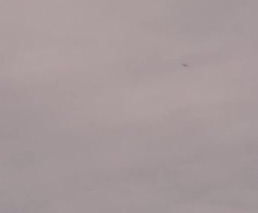

In [205]:
crops[0]

In [176]:
ImageDraw.Draw(crops[0]).rectangle(yolo2xyxy(crops_new_labels[0][0][1:], crops[0].size), fill = None, outline ="red") 

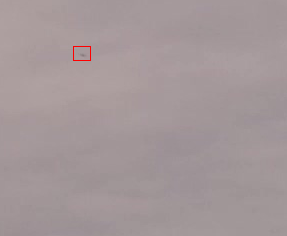

In [177]:
crops[0]

In [185]:
" ".join([str(el) for el in crops_new_labels[0][0]])

'3.0 0.28478513707538927 0.22839948978328536 0.05925925925925926 0.05925925925925928'

In [194]:
save_crop(".", 'test.jpg', crop_image=crops[0], crop_labels=crops_new_labels[0])

test.jpg


In [ ]:
target_dir = "~/hdd/hdd4/Datasets/lct-drones/prod_data_crops"